# CPSC 330 Lecture 16

Outline:

- 👋
- **Turn on recording**
- Announcements
- True/False questions from last time (10 min)
- Outliers: intro (10 min)
- Outlier scavenger hunt (20 min)
- Break (5 min)
- Mean vs median (5 min)
- Effect on trained models (20 min)
- Outlier scenarios (5 min)

Piazza:

- True/False questions


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [114]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest

In [3]:
plt.style.use("seaborn")
plt.rcParams['font.size'] = 16

In [4]:
from pandas_profiling import ProfileReport

## Announcements

- First 9 minutes of Lecture 15 recording were corrupted.
- hw6 released, due next Monday at 11:59pm.
- Golden Rule violation in Lecture 13 - see https://piazza.com/class/kb2e6nwu3uj23?cid=440.
- Midterm grades posted - see https://piazza.com/class/kb2e6nwu3uj23?cid=447.
- This lecture should be moved to the "first half" of the course.
- Next week we'll be talking about data involving time.


## Outliers intro (10 min)

#### What is an outlier?


- Loosely speaking, an **outlier** is an observation that is very different from the others.
- These are also called **anomalies** is certain contexts.
- Let's take a look at these [CPSC 340 slides on outlier detection](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L10.pdf), section on "Global vs. Local Outliers".
- Keep in mind that we can have outliers in our features or in our targets (at least for regresson).

#### Why do we want to find outliers? 

Some main reasons are:

1. Data quality concerns. We want to **remove** the outliers.
2. Our task is actually to **find** (identify, detect) the outliers. E.g. credit card fraud.

Thus, outliers are not categorically good nor bad - it depends on the context.

#### How can we find outliers? Very high level overview.

- Most of outlier detection is unsupervised.
  - There are various approaches, today we'll consider looking at plots and summary statistics.
- But, remember our credit card fraud dataset? That was really supervised anomaly detection!
  - Find the unusual events (frauds) based on labelled data. 
  - Here, we could just use our regular supervised learning techniques.
  
Note: you can have both supervised and unsupervised cases where you want to find anomalies.

#### How can we guard against unwanted outliers?

There are two general strategies:

1. Remove outliers.
2. Use methods that are **robust** to outliers.

## Outlier scavenger hunt (15 min)

#### Census data (lectures 6-7)

In [5]:
df_census = pd.read_csv('data/adult.csv')
census_train, census_test = train_test_split(df_census, test_size=0.2, random_state=123)
census_train.head()

age     workclass  fnlwgt     education  education.num  \
17064   20       Private  110998  Some-college             10   
18434   22       Private  263670       HS-grad              9   
3294    51       Private  335997       HS-grad              9   
31317   53       Private  111939     Bachelors             13   
4770    52  Self-emp-inc   51048     Bachelors             13   

           marital.status       occupation relationship                race  \
17064       Never-married     Adm-clerical    Own-child  Asian-Pac-Islander   
18434       Never-married    Other-service    Own-child               Black   
3294   Married-civ-spouse  Exec-managerial      Husband               White   
31317  Married-civ-spouse    Other-service      Husband               White   
4770   Married-civ-spouse            Sales      Husband               White   

          sex  capital.gain  capital.loss  hours.per.week native.country  \
17064  Female             0             0              30  United-States   
18434    Male             0             0              80  United-States   
3294     Male          4386             0              55  United-States   
31317    Male             0             0              35  United-States   
4770     Male             0             0              55  United-States   

      income  
17064  <=50K  
18434  <=50K  
3294    >50K  
31317  <=50K  
4770   <=50K

In [6]:
census_train.shape

(26048, 15)

In [7]:
profile_census = ProfileReport(census_train, minimal=True)

In [8]:
profile_census.to_notebook_iframe()

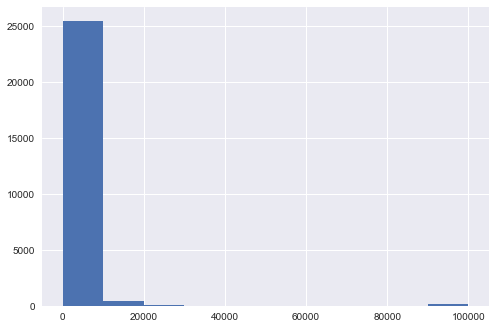

In [9]:
census_train["capital.gain"].hist();

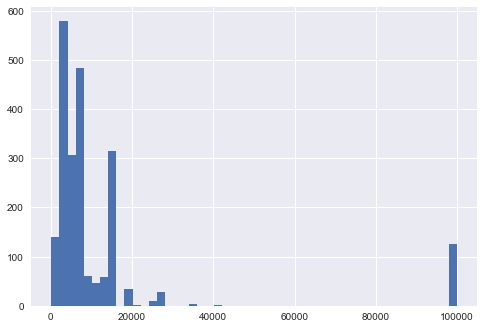

In [10]:
capital_gain = census_train["capital.gain"]
capital_gain[capital_gain > 0].hist(bins=50);

- It looks like we have a small number of individuals with a lot more capital gain than everyone else.
- Could those be outliers?

#### Isolation forests

- Another approach I heard about is isolation forests
- I haven't used these myself but here is the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)
- Conveniently built in to sklearn, we just need to do the feature preprocessing to get this to work:

In [11]:
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 
                    'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'marital.status', 'occupation', 
                        'relationship', 'race', 'sex', 'native.country']
target_column = 'income'
pipe_cat = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
census_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', pipe_cat, categorical_features)
])
census_preprocessor.fit(census_train);

In [12]:
census_columns = numeric_features + list(census_preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names(categorical_features))
census_train_enc = pd.DataFrame(census_preprocessor.transform(census_train), index=census_train.index, columns=census_columns)

In [13]:
isolation = IsolationForest()
predicted_outliers = isolation.fit_predict(census_train_enc) < 0

Above: from the documentation, `predict` returns +1 for inlier and -1 for outlier.

In [14]:
census_train_enc[predicted_outliers].head()

age    fnlwgt  education.num  capital.gain  capital.loss  \
5350   1.792603  5.777232      -3.137604     -0.146669     -0.216807   
22787 -0.924206  0.649300      -2.748829     -0.146669     -0.216807   
18017  0.617767  1.470016      -3.137604     -0.146669     -0.216807   
20639 -0.189933  0.197750      -3.137604     -0.146669     -0.216807   
8316   0.544339  1.134345      -3.137604     -0.146669     -0.216807   

       hours.per.week  workclass_?  workclass_Federal-gov  \
5350        -0.845065          0.0                    0.0   
22787       -0.035091          0.0                    0.0   
18017       -2.303018          0.0                    0.0   
20639       -1.655039          0.0                    0.0   
8316        -0.845065          0.0                    0.0   

       workclass_Local-gov  workclass_Never-worked  ...  \
5350                   0.0                     0.0  ...   
22787                  0.0                     0.0  ...   
18017                  0.0                     0.0  ...   
20639                  0.0                     0.0  ...   
8316                   0.0                     0.0  ...   

       native.country_Portugal  native.country_Puerto-Rico  \
5350                       0.0                         0.0   
22787                      0.0                         0.0   
18017                      0.0                         0.0   
20639                      0.0                         0.0   
8316                       0.0                         0.0   

       native.country_Scotland  native.country_South  native.country_Taiwan  \
5350                       0.0                   0.0                    0.0   
22787                      0.0                   0.0                    0.0   
18017                      0.0                   0.0                    0.0   
20639                      0.0                   0.0                    0.0   
8316                       0.0                   0.0                    0.0   

       native.country_Thailand  native.country_Trinadad&Tobago  \
5350                       0.0                             0.0   
22787                      0.0                             0.0   
18017                      0.0                             0.0   
20639                      0.0                             0.0   
8316                       0.0                             0.0   

       native.country_United-States  native.country_Vietnam  \
5350                            0.0                     0.0   
22787                           0.0                     0.0   
18017                           0.0                     0.0   
20639                           0.0                     0.0   
8316                            0.0                     0.0   

       native.country_Yugoslavia  
5350                         0.0  
22787                        0.0  
18017                        0.0  
20639                        0.0  
8316                         0.0  

[5 rows x 92 columns]

- It found 61 outliers out of around 26,000 training examples.
- We can look at the capital gain of these cases for example:

In [15]:
census_train[predicted_outliers].head()

age         workclass  fnlwgt education  education.num  \
5350    63  Self-emp-not-inc  795830   1st-4th              2   
22787   26           Private  257405   5th-6th              3   
18017   47           Private  343579   1st-4th              2   
20639   36           Private  209993   1st-4th              2   
8316    46           Private  308334   1st-4th              2   

              marital.status       occupation    relationship   race     sex  \
5350                 Widowed    Other-service       Unmarried  White  Female   
22787          Never-married  Farming-fishing  Other-relative  Black    Male   
18017  Married-spouse-absent  Farming-fishing   Not-in-family  White    Male   
20639                Widowed    Other-service  Other-relative  White  Female   
8316                 Widowed    Other-service       Unmarried  Other  Female   

       capital.gain  capital.loss  hours.per.week native.country income  
5350              0             0              30    El-Salvador  <=50K  
22787             0             0              40         Mexico  <=50K  
18017             0             0              12         Mexico  <=50K  
20639             0             0              20         Mexico  <=50K  
8316              0             0              30         Mexico  <=50K

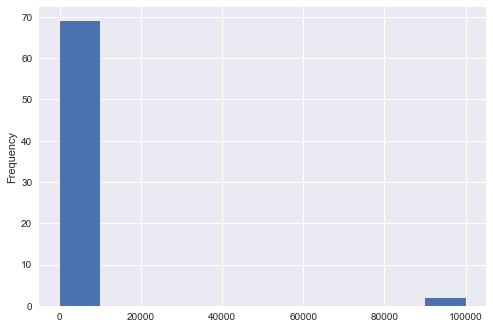

In [16]:
census_train.loc[predicted_outliers, "capital.gain"].plot.hist();

- We see lots of small (typical) values - it's not picking only based on capital gain here, but based on all the features.
- I don't know the details.

#### Movie review data (lectures 4-5)

In [17]:
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_train, imdb_test = train_test_split(imdb_df, random_state=123)
imdb_train.head()

type                                             review  label  \
31450  train  I don't know what that other guy was thinking....    neg   
42809  train  Scott Henderson (Alan Curtis) is unjustly accu...    pos   
52419  train  This film is by far one of my favorites. I saw...  unsup   
45663  train  This is one horror movie based TV show that ge...    pos   
50696  train  Wonderful film that sadly was not released in ...  unsup   

              file  
31450   4556_2.txt  
42809   3529_9.txt  
52419  12178_0.txt  
45663  6098_10.txt  
50696  10627_0.txt

Let's look at a histogram of the lengths of reviews:

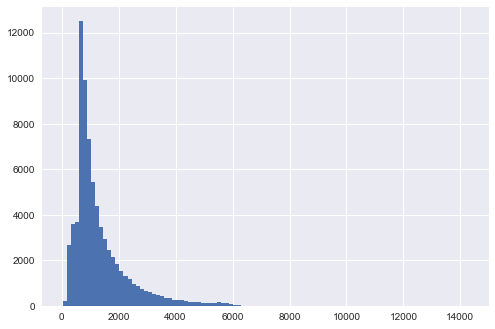

In [18]:
imdb_train["review"].apply(len).hist(bins=100);

In [19]:
imdb_train["review"].apply(len).max()

14282

Wow, that is a long review!

In [20]:
ind = imdb_train["review"].apply(len).argmax()
ind

28943

In [21]:
imdb_train["review"].iloc[ind]

'***SPOILERS*** ***SPOILERS*** The first Godzilla movie in the third movie series, whereas GODZILLA VS. DESTOROYAH, the previous entry, aptly ended the second series. What else can I say? Well, let\'s break it down.<br /><br />I once liked the 2nd series of Godzilla movies (1984-1995), even though I found something annoying about those movies (as either the bad or good guy, Godzilla was so sympathetic that the human characters came off as obnoxious). Then, in 1995, along came a movie called GAMERA: GUARDIAN OF THE UNIVERSE and its two successful sequels, all directed by master filmmaker Shuusuke Kaneko, who singlehandedly changed the face of Japanese monster movies forever. I was spoiled!!! The Series 2 Godzilla movies were suddenly looked down as half-hearted, heavy-handed, auto-piloted and lazy attempts at recreating the "original" Godzilla, and end up being an insult to the memory of genre masters Ishirou Honda and Eiji Tsuburaya. GAMERA 3: THE AWAKENING OF IRIS, released the same y

#### Amazon product ratings data (lecture 14)

In [22]:
df_ratings = pd.read_csv("data/ratings_Patio_Lawn_and_Garden.csv", names=("user","item","rating","timestamp"))
df_ratings.head()

user        item  rating   timestamp
0  A2VNYWOPJ13AFP  0981850006     5.0  1259798400
1  A20DWVV8HML3AW  0981850006     5.0  1371081600
2  A3RVP3YBYYOPRH  0981850006     5.0  1257984000
3  A28XY55TP3Q90O  0981850006     5.0  1314144000
4  A3VZW1BGUQO0V3  0981850006     5.0  1308268800

Probably no outliers here, since ratings are from 1 to 5. But we might have "outlier" products or users in the sense of having given/received way more ratings than typical (see Lecture 14).

#### House price data (lecture 10-11)

In [23]:
housing_df = pd.read_csv("data/housing.csv")
housing_train, housing_test = train_test_split(housing_df, random_state=123)
housing_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1446  1447          20       RL          NaN    26142   Pave   NaN      IR1   
1123  1124          20       RL         50.0     9405   Pave   NaN      Reg   
186    187          80       RL          NaN     9947   Pave   NaN      IR1   
1020  1021          20       RL         60.0     7024   Pave   NaN      Reg   
67      68          20       RL         72.0    10665   Pave   NaN      IR1   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
1446         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1123         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
186          Lvl    AllPub  ...        0    NaN  GdPrv         NaN       0   
1020         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
67           Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1446      4   2010        WD         Normal     157900  
1123      6   2009        WD         Normal     118000  
186       6   2009        WD         Normal     173000  
1020      6   2008        WD         Normal     176000  
67        6   2007        WD         Normal     226000  

[5 rows x 81 columns]

In [24]:
housing_train.shape

(1095, 81)

In [25]:
profile_housing = ProfileReport(housing_train)

In [26]:
profile_housing.to_notebook_iframe()

(Small aside: check out the dendrogram of missing values - we just talked about dendrograms!)

Based on the above, let's look closer at `LotArea`:

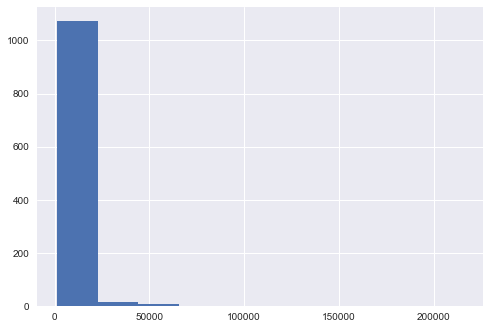

In [27]:
housing_train["LotArea"].hist();

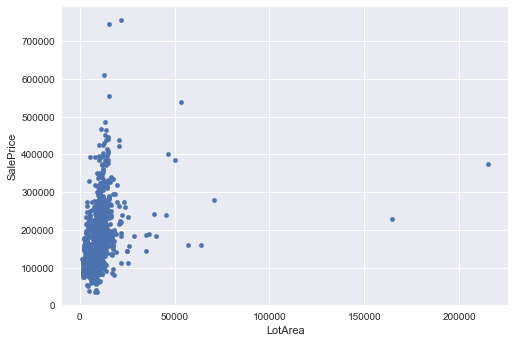

In [28]:
housing_train.plot.scatter(x="LotArea", y="SalePrice");

- Ok, it looks like we have some outliers on our hands!
- Are these outliers a problem?
- Let's look at the scaled version of `LotArea`:

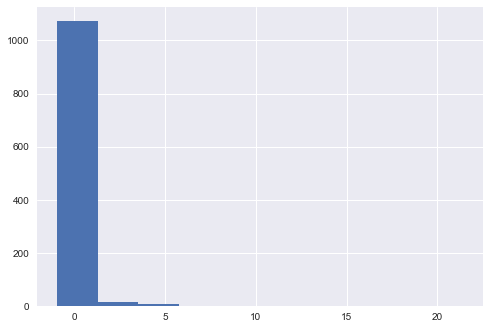

In [29]:
sc = StandardScaler()

area_transformed = sc.fit_transform(housing_train[["LotArea"]])
plt.hist(area_transformed);

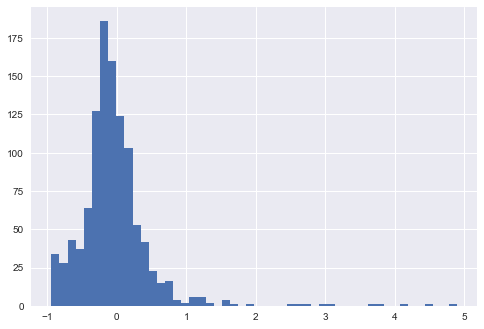

In [30]:
plt.hist(area_transformed[area_transformed < 5], bins=50);

What's happening here is that most of the points are between $-1$ and $1$, but then we have those outliers that are around 20:

In [31]:
area_transformed.max()

21.401850034926778

That is, 20 standard deviations above the mean!

In [32]:
sc.mean_

array([10299.34703196])

In [33]:
np.sqrt(sc.var_)

array([9576.07181779])

Question: what would these values have been without the outliers?

In [34]:
housing_train["LotArea"].mean()

10299.34703196347

In [35]:
housing_train["LotArea"].std()

9580.447450560465

In [36]:
housing_train["LotArea"][housing_train["LotArea"] < 100_000].mean()

9970.612991765782

In [37]:
housing_train["LotArea"][housing_train["LotArea"] < 100_000].std()

5617.925977505592

What about `MinMaxScaler`?

In [38]:
mm = MinMaxScaler()
area_transformed_mm = mm.fit_transform(housing_train[["LotArea"]])

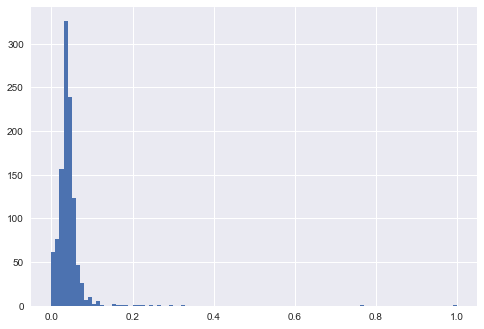

In [39]:
plt.hist(area_transformed_mm, bins=100);

In [40]:
np.percentile(area_transformed_mm, 95)

0.07366986842412768

- The values are supposed to be squished between 0 and 1, but actually 95% of the values are less that 0.075! 
- Question: Why would this be an issue?

<br><br><br><br><br><br>

Because some methods rely on different columns having the same "scale".

- A great comparison of scalers in the presence of outliers can be found [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).
- Here are a couple scalers they mention:

In [41]:
rb = RobustScaler()
area_transformed_rb = rb.fit_transform(housing_train[["LotArea"]])

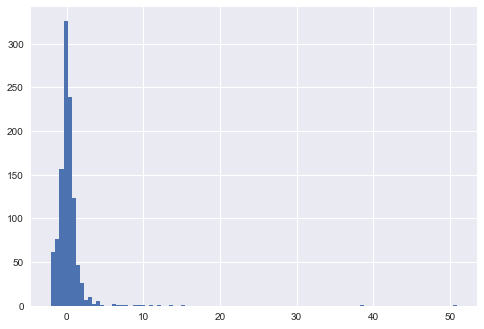

In [42]:
plt.hist(area_transformed_rb, bins=100);

In [43]:
qt = QuantileTransformer()
area_transformed_qt = qt.fit_transform(housing_train[["LotArea"]])

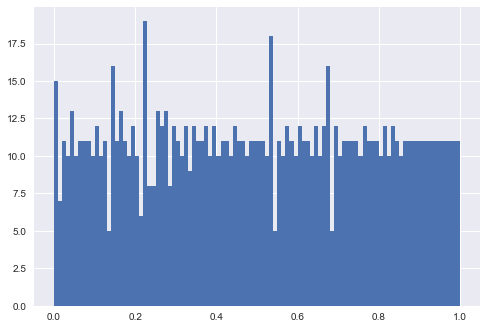

In [44]:
plt.hist(area_transformed_qt, bins=100);

- This transformer gives you a uniform distribution as its output. 
- It basically looks at the _order_ of the values, instead of the values themselves.
- Thus it doesn't care if your outlier is 1 million sq ft or 1 billion sq ft.

In [52]:
lot_area_crazy = housing_train[["LotArea"]].copy()
lot_area_crazy.iloc[0] = 999999999999999

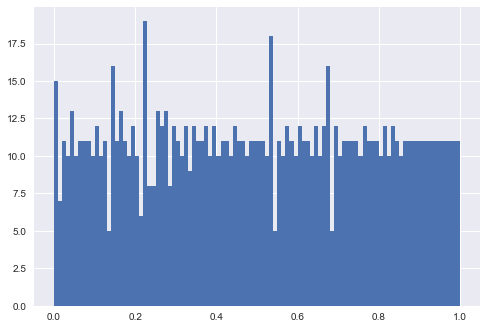

In [55]:
plt.hist(QuantileTransformer().fit_transform(lot_area_crazy), bins=100);

## Break (5 min)

<br>

REMINDER TO RESUME RECORDING

## Mean vs. medians (5 min)

I create a small list of numbers:

In [45]:
x = [1,2,3,4,5,6,7,8,99999]

Let's look at these summary statistics:

In [46]:
np.mean(x)

11115.0

In [47]:
np.median(x)

5.0

In [48]:
np.std(x)

31425.23964374284

In [49]:
np.percentile(x, 75) - np.percentile(x, 25)

4.0

What happens if we change the 9 to 99? Or 99999?

- Because of this effect we say the median is more robust than the mean.
- That is why, for imputation, I tended to choose the median value as "typical".

## Effect on trained models (15 min)

In [57]:
housing_df = pd.read_csv("data/housing.csv", index_col=0)

housing_train, housing_test = train_test_split(housing_df, random_state=123)

X_train = housing_train.drop(columns=['SalePrice'])
y_train = housing_train['SalePrice']

X_test = housing_test.drop(columns=['SalePrice'])
y_test = housing_test['SalePrice']

In [58]:
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(X_train.columns) - set(numeric_features) - set(ordinal_features_reg))

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

In [59]:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())
ordinal_preprocessing = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                      OrdinalEncoder(categories=[ordering]*len(ordinal_features_reg)))
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

In [60]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('ordinal', ordinal_preprocessing, ordinal_features_reg),
    ('categorical', categorical_preprocessing, categorical_features)
])

In [61]:
preprocessing.fit(X_train);

In [62]:
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [63]:
X_train_enc = pd.DataFrame(preprocessing.transform(X_train), index=X_train.index, columns=new_columns)
X_test_enc = pd.DataFrame(preprocessing.transform(X_test), index=X_test.index, columns=new_columns)

X_train_enc.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                 
1447    -0.046315  1.654400    -0.775646     1.255836  -0.282035   
1124    -0.888437 -0.093394    -0.775646     3.019968  -0.773017   
187     -0.046315 -0.036795     0.647021    -0.508295   0.634466   
1021    -0.420591 -0.342035    -1.486980    -0.508295   1.125448   
68       0.140824  0.038184     0.647021    -0.508295   1.059984   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
Id                                                                 ...   
1447     -1.105566    0.491436    0.327430    -0.28498   0.064219  ...   
1124      1.117128   -0.569906   -0.942714    -0.28498   0.297501  ...   
187       0.295697   -0.569906    0.365985    -0.28498   0.023451  ...   
1021      0.972169   -0.569906    1.250588    -0.28498  -1.038776  ...   
68        0.875531    0.367894    1.227027    -0.28498  -0.286837  ...   

      Functional_Maj1  Functional_Maj2  Functional_Min1  Functional_Min2  \
Id                                                                         
1447              0.0              0.0              0.0              0.0   
1124              0.0              0.0              0.0              0.0   
187               0.0              0.0              0.0              0.0   
1021              0.0              0.0              0.0              0.0   
68                0.0              0.0              0.0              0.0   

      Functional_Mod  Functional_Typ  LandContour_Bnk  LandContour_HLS  \
Id                                                                       
1447             0.0             1.0              0.0              0.0   
1124             0.0             1.0              0.0              0.0   
187              0.0             1.0              0.0              0.0   
1021             0.0             1.0              0.0              0.0   
68               0.0             1.0              0.0              0.0   

      LandContour_Low  LandContour_Lvl  
Id                                      
1447              0.0              1.0  
1124              0.0              1.0  
187               0.0              1.0  
1021              0.0              1.0  
68                0.0              1.0  

[5 rows x 292 columns]

In [65]:
X_train_enc.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                 
1447    -0.046315  1.654400    -0.775646     1.255836  -0.282035   
1124    -0.888437 -0.093394    -0.775646     3.019968  -0.773017   
187     -0.046315 -0.036795     0.647021    -0.508295   0.634466   
1021    -0.420591 -0.342035    -1.486980    -0.508295   1.125448   
68       0.140824  0.038184     0.647021    -0.508295   1.059984   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
Id                                                                 ...   
1447     -1.105566    0.491436    0.327430    -0.28498   0.064219  ...   
1124      1.117128   -0.569906   -0.942714    -0.28498   0.297501  ...   
187       0.295697   -0.569906    0.365985    -0.28498   0.023451  ...   
1021      0.972169   -0.569906    1.250588    -0.28498  -1.038776  ...   
68        0.875531    0.367894    1.227027    -0.28498  -0.286837  ...   

      Functional_Maj1  Functional_Maj2  Functional_Min1  Functional_Min2  \
Id                                                                         
1447              0.0              0.0              0.0              0.0   
1124              0.0              0.0              0.0              0.0   
187               0.0              0.0              0.0              0.0   
1021              0.0              0.0              0.0              0.0   
68                0.0              0.0              0.0              0.0   

      Functional_Mod  Functional_Typ  LandContour_Bnk  LandContour_HLS  \
Id                                                                       
1447             0.0             1.0              0.0              0.0   
1124             0.0             1.0              0.0              0.0   
187              0.0             1.0              0.0              0.0   
1021             0.0             1.0              0.0              0.0   
68               0.0             1.0              0.0              0.0   

      LandContour_Low  LandContour_Lvl  
Id                                      
1447              0.0              1.0  
1124              0.0              1.0  
187               0.0              1.0  
1021              0.0              1.0  
68                0.0              1.0  

[5 rows x 292 columns]

In [93]:
lr = Ridge(alpha=100)
lr.fit(X_train_enc, y_train);

In [94]:
lr_coefs = pd.DataFrame(data=lr.coef_, index=X_train_enc.columns, columns=["Coefficient"])
lr_coefs.loc["LotArea"]

Coefficient    3003.005458
Name: LotArea, dtype: float64

In [95]:
X_train_enc["LotArea"].max()

21.401850034926778

In [96]:
ind = X_train_enc["LotArea"].argmax()
ind

163

How does our model predict on that property with huge `LotArea`?

In [97]:
lr.predict(X_train_enc)[ind]

318626.03674174653

In [73]:
y_train.iloc[ind]

375000

There are two issues to consider here:

1. How does the outlier in the _training_ data change the trained model (i.e. coefficients) - `fit()`
2. How does the outlier in the _test_ data affect predictions on that example - `predict()`

The 2nd issue only pertains to outliers in the features; not the target.


What happens if we make a big outlier in `LotArea`?

In [90]:
X_train_corrupted = X_train_enc.copy()
X_train_corrupted.loc[X_train_corrupted.index[0], "LotArea"] = 10_000 # 10_000 standard devs above mean

In [101]:
lr = Ridge(alpha=100)
lr.fit(X_train_corrupted, y_train);

Old coefs:

In [102]:
lr_coefs.head()

Coefficient
LotFrontage  -1959.026983
LotArea       3003.005458
OverallQual  14490.849301
OverallCond   4840.226683
YearBuilt     1843.372943

New coefs:

In [103]:
lr_coefs_x_outlier = pd.DataFrame(data=lr.coef_, index=X_train_enc.columns, columns=["Coefficient"])
lr_coefs_x_outlier.head()

Coefficient
LotFrontage  -1412.290991
LotArea          2.453697
OverallQual  14424.297875
OverallCond   4826.290991
YearBuilt     1755.999762

It was basically forced to ignore `LotArea` to avoid a humongous prediction for that one example.

What happens if we make a big outlier in the targets?

In [104]:
len(y_train)

1095

In [105]:
y_train_corrupted = y_train.copy().values
y_train_corrupted[0] = 1_000_000_000 # $1 billion

In [106]:
lr = Ridge(alpha=100)
lr.fit(X_train_enc, y_train_corrupted);

In [107]:
lr_coefs = pd.DataFrame(data=lr.coef_, index=X_train_enc.columns, columns=["Coefficient"])

In [108]:
lr_coefs.sort_values(by="Coefficient", ascending=False)

Coefficient
PavedDrive_P          6.902202e+06
Neighborhood_Mitchel  6.597829e+06
BsmtFinType1_Rec      4.465575e+06
LotConfig_CulDSac     4.394171e+06
MoSold_4              4.171259e+06
...                            ...
Neighborhood_Sawyer  -1.507493e+06
MasVnrType_None      -1.823774e+06
Neighborhood_NAmes   -1.864995e+06
LotConfig_Inside     -2.470638e+06
PavedDrive_Y         -5.454118e+06

[292 rows x 1 columns]

In [109]:
lr.predict(X_train_enc)[ind]

23712821.84938855

In [110]:
y_train_corrupted[ind]

375000

In [111]:
y_train.iloc[ind]

375000

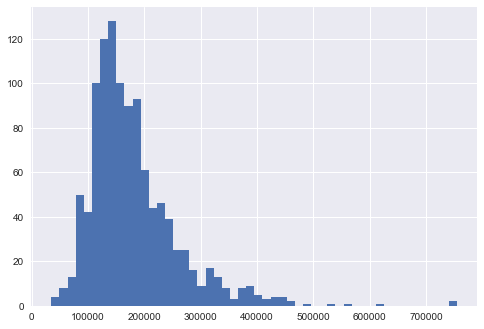

In [112]:
y_train.hist(bins=50);

- This is _not_ the corrupted training example! 
- This crazy prediction is happening for a _different_ training example.

In [113]:
lr.predict(X_train_enc)[0]

63824502.7223924

What if we're log-transforming our targets?

In [118]:
lr = TransformedTargetRegressor(Ridge(alpha=100), func=np.log1p, inverse_func=np.expm1)
lr.fit(X_train_enc, y_train_corrupted);

In [121]:
lr_coefs = pd.DataFrame(data=lr.regressor_.coef_, index=X_train_enc.columns, columns=["Coefficient"])

In [122]:
lr_coefs.sort_values(by="Coefficient", ascending=False)

Coefficient
OverallQual              0.073587
PavedDrive_P             0.062752
OverallCond              0.055144
LotConfig_CulDSac        0.052169
Neighborhood_Mitchel     0.050506
...                           ...
LotConfig_Inside        -0.027992
MSZoning_C (all)        -0.028830
BsmtFinType1_Unf        -0.029970
Neighborhood_Edwards    -0.030938
PavedDrive_Y            -0.037973

[292 rows x 1 columns]

In [123]:
lr.predict(X_train_enc)[0]

234707.6586589173

- Here we're OK because the log-transforming made the $1B house not that bad. 

Yikes!! What about a random forest?

In [ ]:
rf = RandomForestRegressor(max_depth=20, n_estimators=20)
rf.fit(X_train_enc, y_train_corrupted);

In [ ]:
rf.predict(X_train_enc)[ind]

In [ ]:
y_train.iloc[ind]

But what about the prediction on the corrupted point itself:

In [ ]:
rf.predict(X_train_enc)[0]

In [ ]:
y_train_corrupted[0]

In [ ]:
train_predictions = rf.predict(X_train_enc)

In [ ]:
plt.hist(train_predictions, bins=100);

In [ ]:
plt.hist(train_predictions[train_predictions < 1e6], bins=100);

In [ ]:
plt.hist(train_predictions[train_predictions > 1e6], bins=100);

# TODO

- make these histograms for the Ridge 
- we'd see crazy values

- So, we get 10ish crazy predictions (presumably, cases with similar features to the corrupted data point). 
- We can compare this with a random forest trained on the original training data:

In [ ]:
rf_uncorrupted = RandomForestRegressor(max_depth=20, n_estimators=20)
rf_uncorrupted.fit(X_train_enc, y_train);

In [ ]:
train_predictions_unc = rf_uncorrupted.predict(X_train_enc)

In [ ]:
plt.hist(train_predictions_unc, bins=100);

- The linear regression suffered a lot more because the coefficients affect all predictions.
- There are ways around this, e.g. sklearn's [HuberRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html) is like Ridge but robust to outliers **in the targets**.
  - It even tells you the outliers afterward!
- Earlier I said always use `Ridge` over `LinearRegression`.
- So, always use `HuberRegressor` over `Ridge`?
  - As far as the model itself is concerned, yes. 
  - When there are no outliers, `HuberRegressor` will behave about the same as `Ridge.`
  - However, I wouldn't make as strong of a statement this time.
  - The reason is computational reasons - the way `fit()` works with `HuberRegressor` is different, and could be slower.
  - But sure, just to be a bit controversial, let me say always use `Ridge` over `LinearRegression` and always use `HuberRegressor` over `Ridge`.

In [ ]:
from sklearn.linear_model import HuberRegressor

In [ ]:
hr = HuberRegressor(max_iter=1000)
hr.fit(X_train_enc, y_train_corrupted);

In [ ]:
hr_coefs = pd.DataFrame(data=hr.coef_, index=X_train_enc.columns, columns=["Coefficient"])
hr_coefs.loc["LotArea"]

In [ ]:
hr_coefs.sort_values(by="Coefficient", ascending=False)

In [ ]:
hr.predict(X_train_enc)[ind]

In [ ]:
y_train_corrupted[ind]

In [ ]:
y_train.iloc[ind]

# TODO

- explicitly talk about why you can't look at one feature at a time.

## Outlier detection with clustering (0 min)

- No time to cover this in detail, it's a TODO for next term.
- But, you are asked to think about this in the last part of hw7.

## Supervised outlier detection (0 min)

#### Credit card fraud data (lecture 8)

In [ ]:
df_credit = pd.read_csv('data/creditcard.csv', encoding='latin-1')
df_credit.head()

- We looked at this dataset for another reason, but this is really an anomaly detection problem!

## Outlier scenarios (5 min)

- Outliers are not always "bad".
- Remember when we talked about unbalanced training sets?
- We needed to ask ourselves two important questions:
  1. Are the deployment data and the training data coming from the same "distribution"?
  2. What types of mistakes are we most worried about?
   

#### House price example

Train vs. deploy? There are a few cases:

1. Train/deploy same distribution
  - the same software bug for recording `LotArea` will affect both train/test and deployment.
2. Outliers only in training data
  - the buggy software is only used to collect training data; or, the buggy software only affects our measurements of our target (house price)
3. Outliers only in deployment features
  - the training set is fine, but in deployment 

What do we care about? There are also cases:

1. We don't care about outliers (they are "mistakes" or we just don't care about predicting well on them)
  - software bug corrupted the `LotArea` for certain properties
  - we want to remove these
2. We want to predict correctly on outliers (they are "real data")
  - some properties genuinely have a huge `LotArea` and we want to predict well on such cases in deployment


#### This sounds like a huge mess, what should I do??
 
- Keep in mind that outliers are a tricky problem.
- Think carefully about how you want to treat outliers. 
- If they are "bad outliers"
  - Consider methods that are insensitive to outliers (e.g. Huber regression)
  - Consider explicitly finding and removing the outliers (e.g. via EDA)
- (Usually) Trust your validation/test scores, but not always!

## Summary (5 min)

- Outliers are everywhere
- Outliers are often undesireable, but not always!
- There are several ways of detecting outliers.
  - Visually
  - Clustering
  - Supervised learning (if labels are available)
  - Other approaches (see [CPSC 340 slides](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L10.pdf))
- Different summary statistics behave differently w.r.t. outliers
  - e.g. mean vs. median
- Different preprocessing methods behave differently w.r.t. outliers
  - e.g. `MinMaxScaler`
- Different models behave different w.r.t. outliers
  - e.g. `Ridge` vs. `HuberRegressor` or `RandomForestRegressor`
- One should carefully consider where the outliers might be occurring:
  - Train vs. deploy
  - X vs. y

## True/False questions (15 min)

1. Outliers in the target values are not an issue for classification problems.
2. Outliers in the target values are not an issue in the deployment phrase.
3. Some outliers cannot be detected by looking at the individual feature histograms.
4. Consider the case of one big outlier in a feature vs. many rows with that unusually large/small value. `StandardScaler` behaves the same in both cases.
5. Consider the case of one big outlier in a feature vs. many rows with that unusually large/small value. `MinMaxScaler` behaves the same in both cases.